# Setup

In [1]:
import os
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from zipfile import ZipFile
import PIL
from PIL import Image
import math

import warnings
import tensorflow as tf


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


# Creating image paths

In [5]:
with ZipFile('nhl_images.zip', 'r') as zipObj:
    # Extract all the contents of zip file in different directory
    zipObj.extractall("./hockey_data")

In [3]:
data_dir="./hockey_data/nhl_data/"

In [4]:
playerimg_paths=[];
for filename in os.listdir(data_dir):
    playerimg_paths.append(data_dir+filename)

## Tools for image processing

In [5]:
def get_batch(image_files, x,y,width, height):
    
    data_batch = np.array([cropresize_array(img, x, y, width, height) for img in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [6]:
def cropresize_array(img, x, y, width, height):
    img=Image.open(img)
    cropped_img=img.crop((x,y,x+width,y+height))
    resized_img=cropped_img.resize([28,28], PIL.Image.LANCZOS)
    
    return np.array(resized_img.convert("RGB"))

In [7]:
class Dataset(object):
    def __init__(self, dataset_name, data_files):
        
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28
        image_channels=3

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels
        self.image_mode="RGB"

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255
        start_x=10;
        start_y=5;
        crop_width=40;
        crop_height=crop_width;



        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                start_x,
                start_y,
                crop_width,
                crop_height)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

## Model functions

In [8]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_input, z_input, learning_rate)


In [9]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d1 = tf.nn.dropout(c1, keep_prob=keep_prob)
        reul1 = tf.maximum(alpha*d1, d1)
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d2 = tf.nn.dropout(c2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d3 = tf.nn.dropout(c3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [10]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME',
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3
        out = tf.tanh(logits)
        return out

In [11]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_prob=0.8):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_faked = generator(input_z, out_channel_dim, is_train=True, alpha=alpha, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True, alpha=alpha, keep_prob=keep_prob)
    
    # Add smoothing to reduce labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=(tf.ones_like(d_model_fake))
        )
    )
    
    return d_loss, g_loss

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [73]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    alpha = 0.12
    keep_prob = 0.75
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_tf = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=alpha, keep_prob=keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    current_step = 0
    print_loss_every = 10
    show_image_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    single_img=show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                    pyplot.imshow(single_img);
                    pyplot.show()
                

# Visualization functions

In [74]:
def images_square_grid(images, mode="RGB"):

    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    new_single=images[np.random.randint(0,len(images)-1)]
    
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im, new_single;

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid, image_single = images_square_grid(samples, image_mode)
    f1=pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return image_single

# Training and output

Epoch 0/40... Discriminator Loss: 4.3237... Generator Loss: 0.0345
Epoch 0/40... Discriminator Loss: 0.6288... Generator Loss: 1.6668
Epoch 0/40... Discriminator Loss: 0.9486... Generator Loss: 1.2413
Epoch 0/40... Discriminator Loss: 0.5304... Generator Loss: 3.1967
Epoch 0/40... Discriminator Loss: 0.5099... Generator Loss: 2.2941


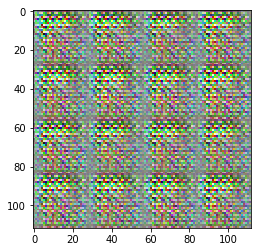

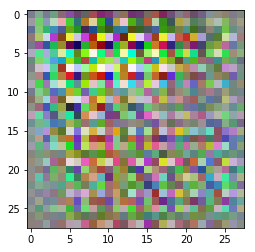

Epoch 0/40... Discriminator Loss: 0.7439... Generator Loss: 1.5417
Epoch 0/40... Discriminator Loss: 0.7161... Generator Loss: 2.6391
Epoch 1/40... Discriminator Loss: 0.8004... Generator Loss: 1.0883
Epoch 1/40... Discriminator Loss: 1.2279... Generator Loss: 0.7047
Epoch 1/40... Discriminator Loss: 0.6913... Generator Loss: 2.0921


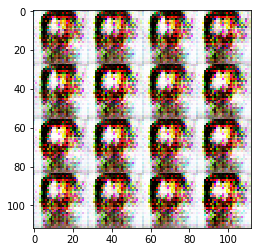

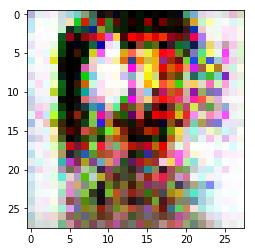

Epoch 1/40... Discriminator Loss: 0.6245... Generator Loss: 2.3848
Epoch 1/40... Discriminator Loss: 0.5337... Generator Loss: 3.0662
Epoch 1/40... Discriminator Loss: 0.7684... Generator Loss: 2.1544
Epoch 1/40... Discriminator Loss: 0.6157... Generator Loss: 2.0486
Epoch 2/40... Discriminator Loss: 0.4991... Generator Loss: 2.5503


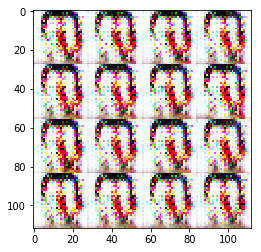

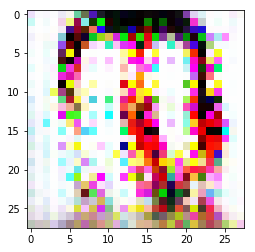

Epoch 2/40... Discriminator Loss: 0.5647... Generator Loss: 2.5147
Epoch 2/40... Discriminator Loss: 0.5173... Generator Loss: 2.7007
Epoch 2/40... Discriminator Loss: 0.7919... Generator Loss: 2.1970
Epoch 2/40... Discriminator Loss: 0.4089... Generator Loss: 3.1614
Epoch 2/40... Discriminator Loss: 0.5217... Generator Loss: 3.1068


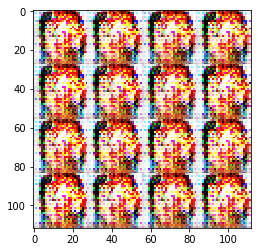

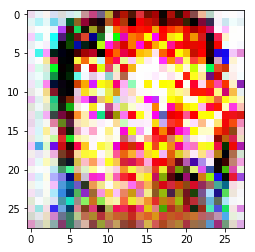

Epoch 2/40... Discriminator Loss: 0.5472... Generator Loss: 2.2827
Epoch 3/40... Discriminator Loss: 0.4702... Generator Loss: 2.9802
Epoch 3/40... Discriminator Loss: 0.4013... Generator Loss: 3.6130
Epoch 3/40... Discriminator Loss: 0.4758... Generator Loss: 2.5248
Epoch 3/40... Discriminator Loss: 0.4894... Generator Loss: 2.4979


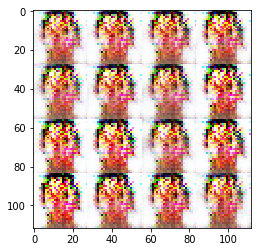

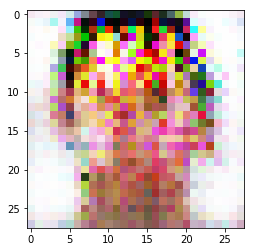

Epoch 3/40... Discriminator Loss: 0.4496... Generator Loss: 3.1644
Epoch 3/40... Discriminator Loss: 0.4616... Generator Loss: 2.5275
Epoch 3/40... Discriminator Loss: 0.3881... Generator Loss: 4.0291
Epoch 4/40... Discriminator Loss: 0.4785... Generator Loss: 3.1709
Epoch 4/40... Discriminator Loss: 0.4827... Generator Loss: 2.9927


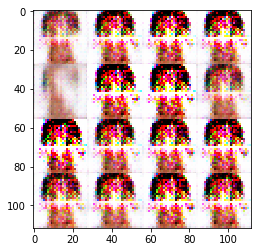

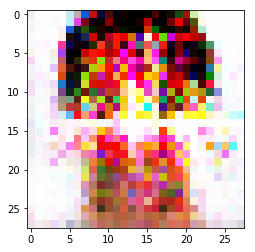

Epoch 4/40... Discriminator Loss: 0.4064... Generator Loss: 3.5185
Epoch 4/40... Discriminator Loss: 0.4753... Generator Loss: 2.6169
Epoch 4/40... Discriminator Loss: 0.5172... Generator Loss: 2.5831
Epoch 4/40... Discriminator Loss: 0.5798... Generator Loss: 2.5192
Epoch 4/40... Discriminator Loss: 0.8612... Generator Loss: 1.9290


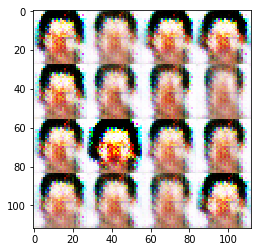

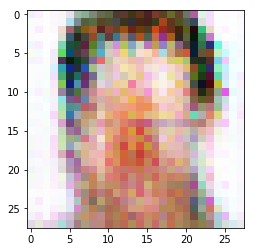

Epoch 4/40... Discriminator Loss: 0.6768... Generator Loss: 2.0456
Epoch 5/40... Discriminator Loss: 1.0123... Generator Loss: 1.2827
Epoch 5/40... Discriminator Loss: 0.5661... Generator Loss: 2.1105
Epoch 5/40... Discriminator Loss: 0.7518... Generator Loss: 1.8716
Epoch 5/40... Discriminator Loss: 0.8305... Generator Loss: 1.5336


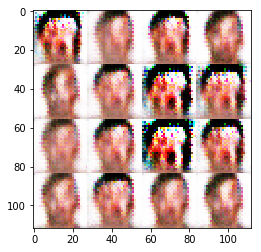

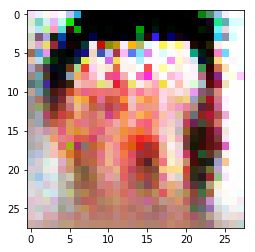

Epoch 5/40... Discriminator Loss: 0.7732... Generator Loss: 1.8456
Epoch 5/40... Discriminator Loss: 1.2183... Generator Loss: 0.9956
Epoch 5/40... Discriminator Loss: 1.0542... Generator Loss: 1.3768
Epoch 6/40... Discriminator Loss: 0.6621... Generator Loss: 1.9850
Epoch 6/40... Discriminator Loss: 0.8350... Generator Loss: 1.3537


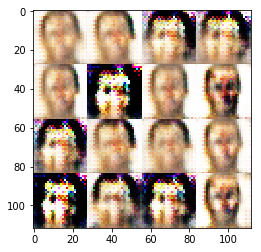

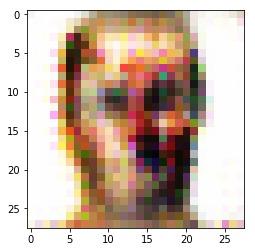

Epoch 6/40... Discriminator Loss: 0.6744... Generator Loss: 2.5048
Epoch 6/40... Discriminator Loss: 0.6644... Generator Loss: 1.6929
Epoch 6/40... Discriminator Loss: 1.3073... Generator Loss: 1.6648
Epoch 6/40... Discriminator Loss: 0.8960... Generator Loss: 1.6892
Epoch 6/40... Discriminator Loss: 0.6748... Generator Loss: 2.0757


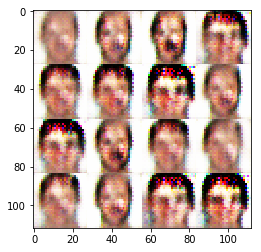

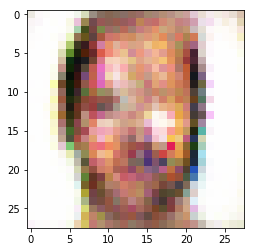

Epoch 7/40... Discriminator Loss: 0.7721... Generator Loss: 1.6196
Epoch 7/40... Discriminator Loss: 0.6784... Generator Loss: 1.6237
Epoch 7/40... Discriminator Loss: 1.0597... Generator Loss: 1.1909
Epoch 7/40... Discriminator Loss: 1.0738... Generator Loss: 1.9118
Epoch 7/40... Discriminator Loss: 0.9099... Generator Loss: 1.7544


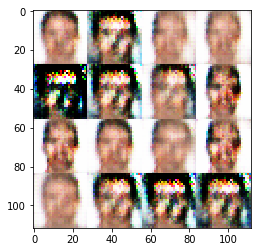

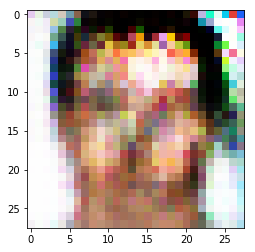

Epoch 7/40... Discriminator Loss: 1.0198... Generator Loss: 1.6929
Epoch 7/40... Discriminator Loss: 0.9000... Generator Loss: 1.4428
Epoch 8/40... Discriminator Loss: 0.7067... Generator Loss: 2.4687
Epoch 8/40... Discriminator Loss: 0.7825... Generator Loss: 1.6008
Epoch 8/40... Discriminator Loss: 0.8174... Generator Loss: 1.4866


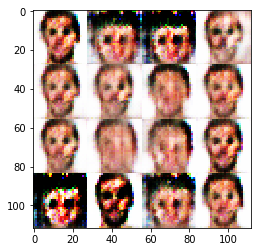

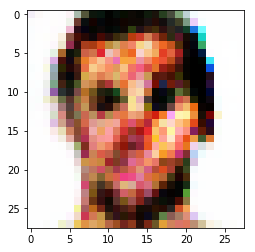

Epoch 8/40... Discriminator Loss: 0.5776... Generator Loss: 2.1634
Epoch 8/40... Discriminator Loss: 0.9152... Generator Loss: 1.6375
Epoch 8/40... Discriminator Loss: 0.8866... Generator Loss: 2.0275
Epoch 8/40... Discriminator Loss: 1.1273... Generator Loss: 1.0261
Epoch 9/40... Discriminator Loss: 0.8736... Generator Loss: 1.4784


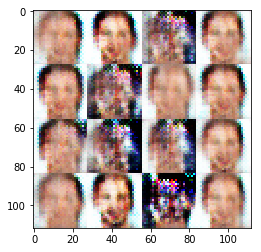

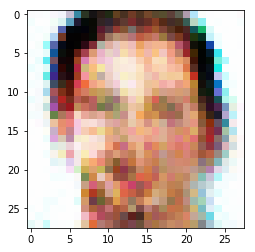

Epoch 9/40... Discriminator Loss: 1.0779... Generator Loss: 0.9436
Epoch 9/40... Discriminator Loss: 0.8942... Generator Loss: 1.8891
Epoch 9/40... Discriminator Loss: 0.7877... Generator Loss: 1.6376
Epoch 9/40... Discriminator Loss: 0.8857... Generator Loss: 1.7161
Epoch 9/40... Discriminator Loss: 0.9374... Generator Loss: 1.6061


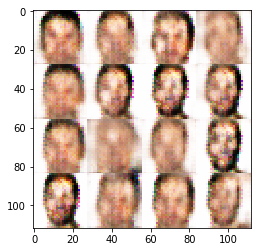

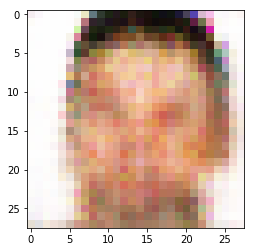

Epoch 9/40... Discriminator Loss: 0.9928... Generator Loss: 1.3076
Epoch 9/40... Discriminator Loss: 0.9467... Generator Loss: 1.8170
Epoch 10/40... Discriminator Loss: 1.2790... Generator Loss: 1.0955
Epoch 10/40... Discriminator Loss: 0.9017... Generator Loss: 1.2467
Epoch 10/40... Discriminator Loss: 0.9588... Generator Loss: 1.5220


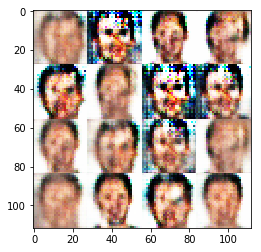

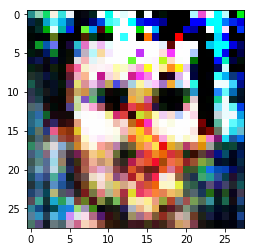

Epoch 10/40... Discriminator Loss: 0.8264... Generator Loss: 1.5616
Epoch 10/40... Discriminator Loss: 1.0716... Generator Loss: 1.4249
Epoch 10/40... Discriminator Loss: 1.1435... Generator Loss: 0.8622
Epoch 10/40... Discriminator Loss: 1.1115... Generator Loss: 1.2483
Epoch 11/40... Discriminator Loss: 0.9625... Generator Loss: 1.5429


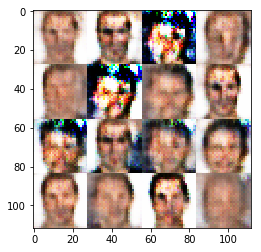

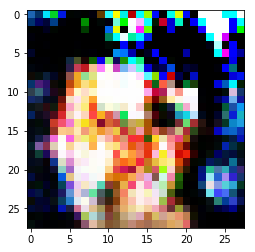

Epoch 11/40... Discriminator Loss: 0.8624... Generator Loss: 1.1944
Epoch 11/40... Discriminator Loss: 0.9950... Generator Loss: 1.2035
Epoch 11/40... Discriminator Loss: 1.1543... Generator Loss: 0.9116
Epoch 11/40... Discriminator Loss: 0.7363... Generator Loss: 1.6725
Epoch 11/40... Discriminator Loss: 0.9657... Generator Loss: 1.5714


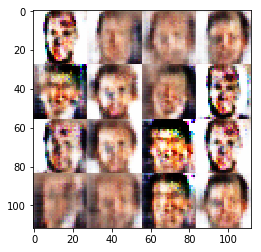

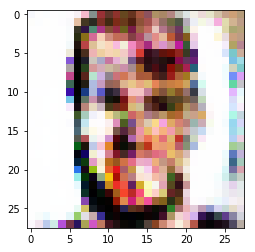

Epoch 11/40... Discriminator Loss: 1.0437... Generator Loss: 1.3377
Epoch 12/40... Discriminator Loss: 1.0183... Generator Loss: 1.2562
Epoch 12/40... Discriminator Loss: 0.8568... Generator Loss: 1.5433
Epoch 12/40... Discriminator Loss: 0.9399... Generator Loss: 1.1901
Epoch 12/40... Discriminator Loss: 0.8667... Generator Loss: 1.4166


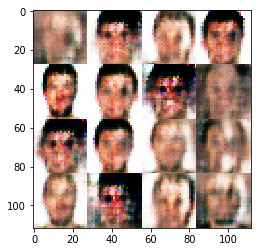

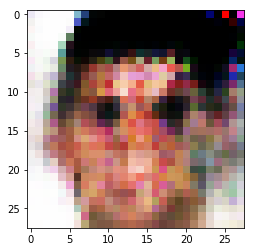

Epoch 12/40... Discriminator Loss: 0.9027... Generator Loss: 1.5318
Epoch 12/40... Discriminator Loss: 1.1062... Generator Loss: 1.0810
Epoch 12/40... Discriminator Loss: 0.9403... Generator Loss: 1.8270
Epoch 13/40... Discriminator Loss: 0.9217... Generator Loss: 1.4646
Epoch 13/40... Discriminator Loss: 1.2485... Generator Loss: 0.7478


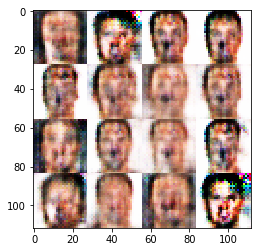

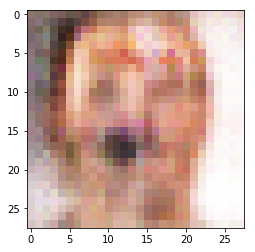

Epoch 13/40... Discriminator Loss: 1.2251... Generator Loss: 1.2376
Epoch 13/40... Discriminator Loss: 0.9654... Generator Loss: 1.9840
Epoch 13/40... Discriminator Loss: 0.9288... Generator Loss: 1.7133
Epoch 13/40... Discriminator Loss: 1.3900... Generator Loss: 1.0941
Epoch 13/40... Discriminator Loss: 1.5613... Generator Loss: 0.7143


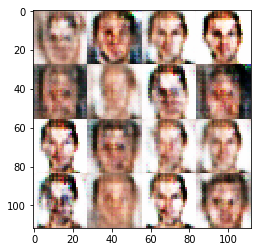

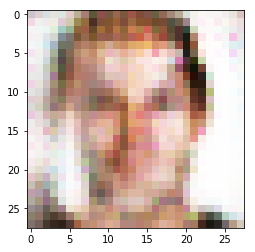

Epoch 14/40... Discriminator Loss: 1.1268... Generator Loss: 1.0776
Epoch 14/40... Discriminator Loss: 0.9832... Generator Loss: 1.1524
Epoch 14/40... Discriminator Loss: 1.4267... Generator Loss: 0.9943
Epoch 14/40... Discriminator Loss: 1.2046... Generator Loss: 1.1511
Epoch 14/40... Discriminator Loss: 1.1598... Generator Loss: 1.2814


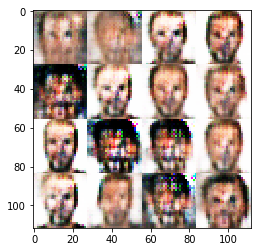

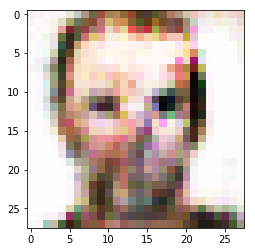

Epoch 14/40... Discriminator Loss: 1.0843... Generator Loss: 0.8633
Epoch 14/40... Discriminator Loss: 1.1593... Generator Loss: 1.7262
Epoch 14/40... Discriminator Loss: 0.8760... Generator Loss: 1.5648
Epoch 15/40... Discriminator Loss: 0.9580... Generator Loss: 1.3669
Epoch 15/40... Discriminator Loss: 1.0784... Generator Loss: 1.0214


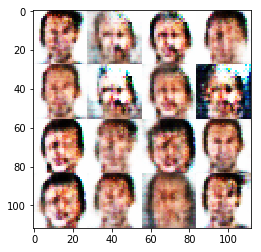

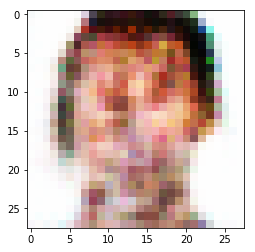

Epoch 15/40... Discriminator Loss: 1.2219... Generator Loss: 1.1924
Epoch 15/40... Discriminator Loss: 1.4125... Generator Loss: 1.4386
Epoch 15/40... Discriminator Loss: 0.9720... Generator Loss: 1.3559
Epoch 15/40... Discriminator Loss: 1.1868... Generator Loss: 1.4665
Epoch 15/40... Discriminator Loss: 1.3039... Generator Loss: 1.1077


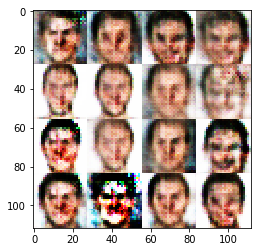

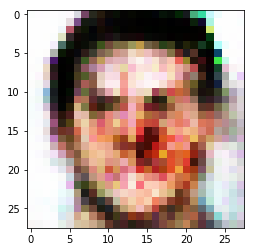

Epoch 16/40... Discriminator Loss: 1.1284... Generator Loss: 1.0680
Epoch 16/40... Discriminator Loss: 0.9622... Generator Loss: 1.3889
Epoch 16/40... Discriminator Loss: 1.0645... Generator Loss: 1.1335
Epoch 16/40... Discriminator Loss: 1.1074... Generator Loss: 1.6345
Epoch 16/40... Discriminator Loss: 0.9810... Generator Loss: 1.3397


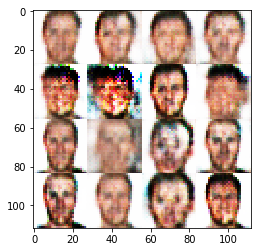

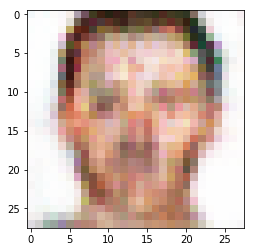

Epoch 16/40... Discriminator Loss: 1.1742... Generator Loss: 0.8794
Epoch 16/40... Discriminator Loss: 1.1347... Generator Loss: 1.0489
Epoch 17/40... Discriminator Loss: 1.1796... Generator Loss: 0.8226
Epoch 17/40... Discriminator Loss: 0.8973... Generator Loss: 1.3571
Epoch 17/40... Discriminator Loss: 1.0977... Generator Loss: 1.0923


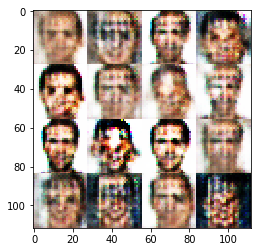

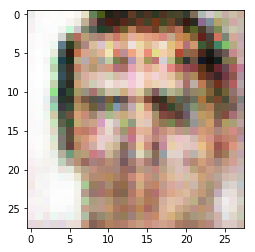

Epoch 17/40... Discriminator Loss: 0.9593... Generator Loss: 1.7697
Epoch 17/40... Discriminator Loss: 0.9652... Generator Loss: 1.1767
Epoch 17/40... Discriminator Loss: 1.1703... Generator Loss: 1.2322
Epoch 17/40... Discriminator Loss: 0.8371... Generator Loss: 1.8665
Epoch 18/40... Discriminator Loss: 1.0746... Generator Loss: 1.1864


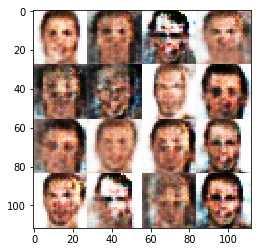

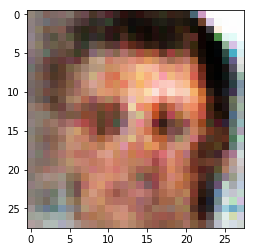

Epoch 18/40... Discriminator Loss: 0.8781... Generator Loss: 1.3456
Epoch 18/40... Discriminator Loss: 1.3826... Generator Loss: 0.9597
Epoch 18/40... Discriminator Loss: 1.2918... Generator Loss: 1.2607
Epoch 18/40... Discriminator Loss: 1.2611... Generator Loss: 0.9906
Epoch 18/40... Discriminator Loss: 0.8803... Generator Loss: 1.3671


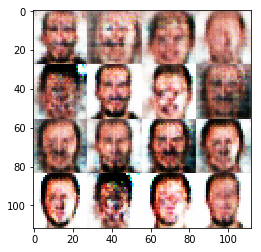

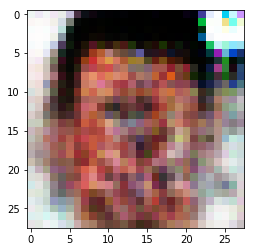

Epoch 18/40... Discriminator Loss: 1.4322... Generator Loss: 0.7480
Epoch 19/40... Discriminator Loss: 0.9621... Generator Loss: 1.2633
Epoch 19/40... Discriminator Loss: 1.0566... Generator Loss: 1.4149
Epoch 19/40... Discriminator Loss: 1.1641... Generator Loss: 1.1040
Epoch 19/40... Discriminator Loss: 1.1297... Generator Loss: 1.3854


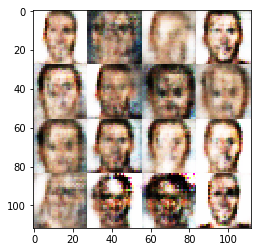

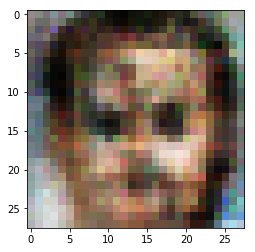

Epoch 19/40... Discriminator Loss: 1.1928... Generator Loss: 1.3106
Epoch 19/40... Discriminator Loss: 1.2446... Generator Loss: 1.3041
Epoch 19/40... Discriminator Loss: 0.9907... Generator Loss: 1.3711
Epoch 19/40... Discriminator Loss: 1.1773... Generator Loss: 1.2624
Epoch 20/40... Discriminator Loss: 1.0877... Generator Loss: 1.2558


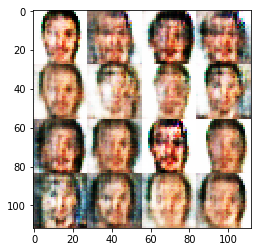

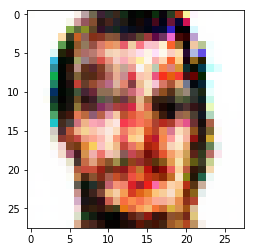

Epoch 20/40... Discriminator Loss: 1.1927... Generator Loss: 1.2003
Epoch 20/40... Discriminator Loss: 1.0118... Generator Loss: 1.5193
Epoch 20/40... Discriminator Loss: 0.9956... Generator Loss: 1.3248
Epoch 20/40... Discriminator Loss: 1.2927... Generator Loss: 0.8801
Epoch 20/40... Discriminator Loss: 1.3866... Generator Loss: 0.8634


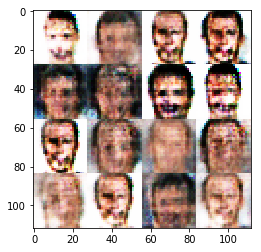

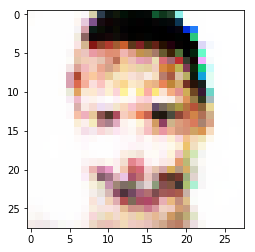

Epoch 20/40... Discriminator Loss: 1.2189... Generator Loss: 1.0846
Epoch 21/40... Discriminator Loss: 1.0701... Generator Loss: 1.4231
Epoch 21/40... Discriminator Loss: 0.8526... Generator Loss: 1.5581
Epoch 21/40... Discriminator Loss: 0.8998... Generator Loss: 1.3927
Epoch 21/40... Discriminator Loss: 1.2727... Generator Loss: 1.1055


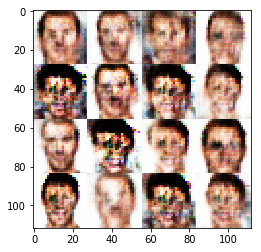

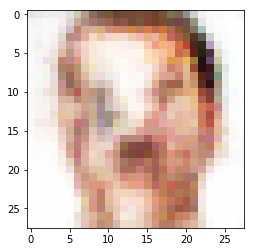

Epoch 21/40... Discriminator Loss: 1.1768... Generator Loss: 1.2017
Epoch 21/40... Discriminator Loss: 1.4475... Generator Loss: 1.0987
Epoch 21/40... Discriminator Loss: 1.3112... Generator Loss: 1.2876
Epoch 22/40... Discriminator Loss: 0.9899... Generator Loss: 1.6704
Epoch 22/40... Discriminator Loss: 1.3130... Generator Loss: 0.9866


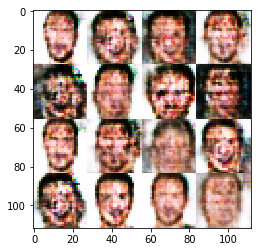

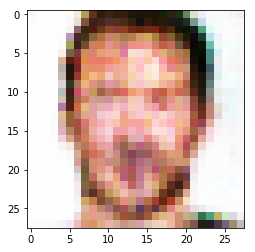

Epoch 22/40... Discriminator Loss: 0.9453... Generator Loss: 2.1364
Epoch 22/40... Discriminator Loss: 1.2584... Generator Loss: 0.8836
Epoch 22/40... Discriminator Loss: 1.3461... Generator Loss: 1.0183
Epoch 22/40... Discriminator Loss: 1.0489... Generator Loss: 1.1245
Epoch 22/40... Discriminator Loss: 1.1808... Generator Loss: 2.4266


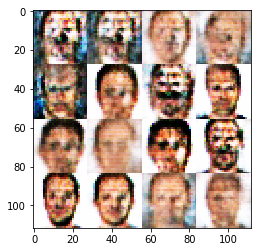

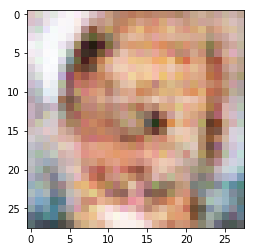

Epoch 23/40... Discriminator Loss: 0.9628... Generator Loss: 1.1280
Epoch 23/40... Discriminator Loss: 0.9238... Generator Loss: 1.3280
Epoch 23/40... Discriminator Loss: 1.0709... Generator Loss: 1.0748
Epoch 23/40... Discriminator Loss: 0.8843... Generator Loss: 1.7784
Epoch 23/40... Discriminator Loss: 1.1945... Generator Loss: 0.9078


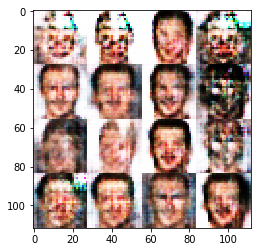

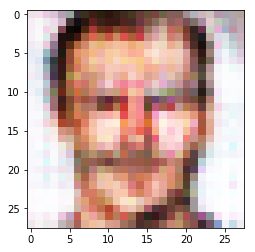

Epoch 23/40... Discriminator Loss: 0.8773... Generator Loss: 1.3109
Epoch 23/40... Discriminator Loss: 0.9751... Generator Loss: 1.4764
Epoch 24/40... Discriminator Loss: 1.0200... Generator Loss: 1.5389
Epoch 24/40... Discriminator Loss: 1.0541... Generator Loss: 1.3047
Epoch 24/40... Discriminator Loss: 1.0765... Generator Loss: 1.3520


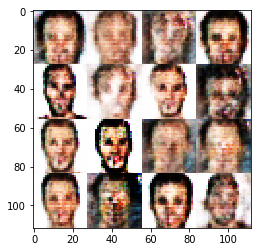

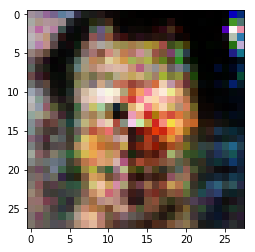

Epoch 24/40... Discriminator Loss: 1.2664... Generator Loss: 1.1749
Epoch 24/40... Discriminator Loss: 1.1921... Generator Loss: 1.4530
Epoch 24/40... Discriminator Loss: 1.2424... Generator Loss: 2.2045
Epoch 24/40... Discriminator Loss: 1.2526... Generator Loss: 0.9817
Epoch 24/40... Discriminator Loss: 1.0028... Generator Loss: 1.1552


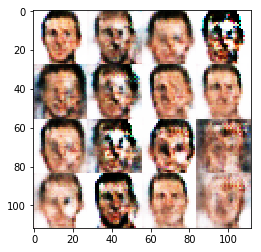

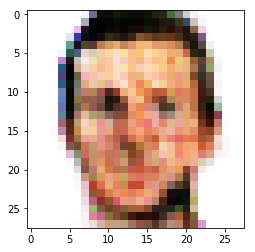

Epoch 25/40... Discriminator Loss: 1.1081... Generator Loss: 1.5547
Epoch 25/40... Discriminator Loss: 1.1891... Generator Loss: 0.9463
Epoch 25/40... Discriminator Loss: 1.1732... Generator Loss: 1.4066
Epoch 25/40... Discriminator Loss: 1.0572... Generator Loss: 1.0611
Epoch 25/40... Discriminator Loss: 1.1848... Generator Loss: 1.0450


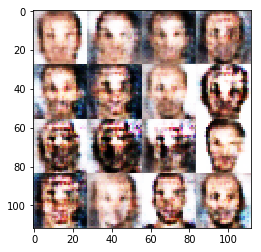

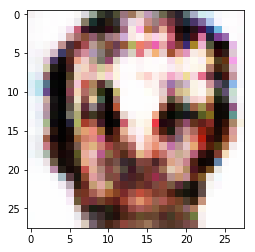

Epoch 25/40... Discriminator Loss: 1.0301... Generator Loss: 1.1318
Epoch 25/40... Discriminator Loss: 1.0624... Generator Loss: 1.4740
Epoch 26/40... Discriminator Loss: 1.1031... Generator Loss: 1.0343
Epoch 26/40... Discriminator Loss: 1.0065... Generator Loss: 1.3207
Epoch 26/40... Discriminator Loss: 1.1841... Generator Loss: 1.0922


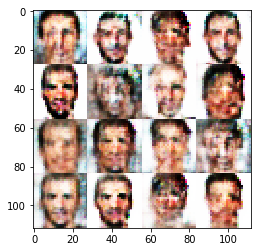

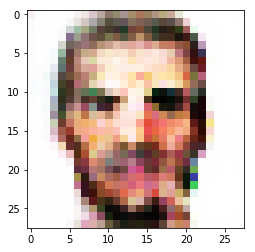

Epoch 26/40... Discriminator Loss: 0.9976... Generator Loss: 1.2713
Epoch 26/40... Discriminator Loss: 1.2401... Generator Loss: 1.0064
Epoch 26/40... Discriminator Loss: 0.9789... Generator Loss: 0.9920
Epoch 26/40... Discriminator Loss: 0.9511... Generator Loss: 1.2811
Epoch 27/40... Discriminator Loss: 1.1697... Generator Loss: 1.2510


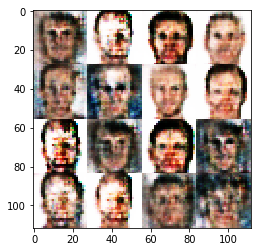

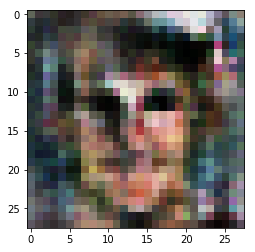

Epoch 27/40... Discriminator Loss: 1.1082... Generator Loss: 1.2006
Epoch 27/40... Discriminator Loss: 1.0035... Generator Loss: 1.3262
Epoch 27/40... Discriminator Loss: 0.9643... Generator Loss: 1.2895
Epoch 27/40... Discriminator Loss: 0.9694... Generator Loss: 1.4000
Epoch 27/40... Discriminator Loss: 1.1524... Generator Loss: 1.0739


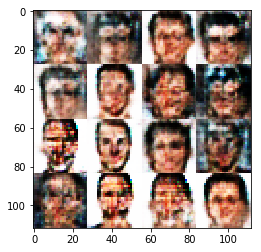

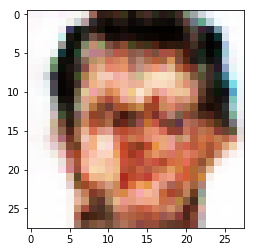

Epoch 27/40... Discriminator Loss: 1.3554... Generator Loss: 1.1213
Epoch 28/40... Discriminator Loss: 1.1105... Generator Loss: 1.2827
Epoch 28/40... Discriminator Loss: 1.2814... Generator Loss: 0.7064
Epoch 28/40... Discriminator Loss: 1.0699... Generator Loss: 1.5274
Epoch 28/40... Discriminator Loss: 0.8386... Generator Loss: 1.4393


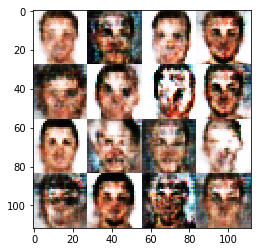

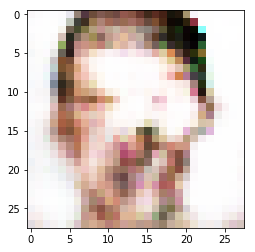

Epoch 28/40... Discriminator Loss: 0.9201... Generator Loss: 1.7655
Epoch 28/40... Discriminator Loss: 0.9577... Generator Loss: 1.1951
Epoch 28/40... Discriminator Loss: 1.3419... Generator Loss: 0.6908
Epoch 29/40... Discriminator Loss: 0.9568... Generator Loss: 1.6026
Epoch 29/40... Discriminator Loss: 0.9610... Generator Loss: 1.5714


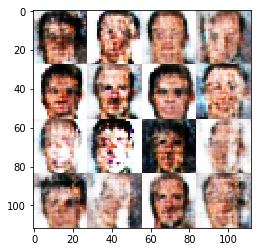

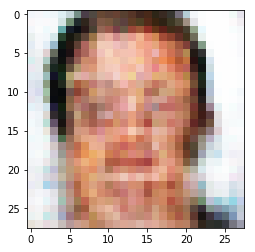

Epoch 29/40... Discriminator Loss: 0.9429... Generator Loss: 1.4039
Epoch 29/40... Discriminator Loss: 1.1513... Generator Loss: 1.0674
Epoch 29/40... Discriminator Loss: 0.9977... Generator Loss: 1.4558
Epoch 29/40... Discriminator Loss: 0.8636... Generator Loss: 1.5287
Epoch 29/40... Discriminator Loss: 0.9436... Generator Loss: 1.4023


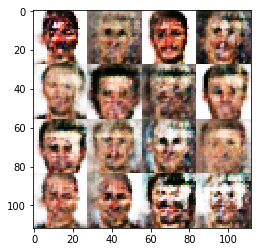

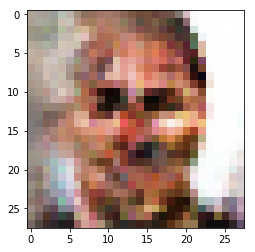

Epoch 29/40... Discriminator Loss: 0.9464... Generator Loss: 1.8783
Epoch 30/40... Discriminator Loss: 1.2062... Generator Loss: 1.4703
Epoch 30/40... Discriminator Loss: 1.0265... Generator Loss: 1.1631
Epoch 30/40... Discriminator Loss: 1.0899... Generator Loss: 1.4276
Epoch 30/40... Discriminator Loss: 0.9417... Generator Loss: 1.2990


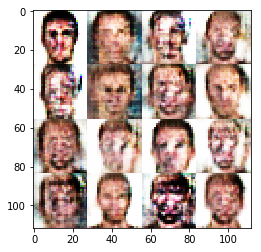

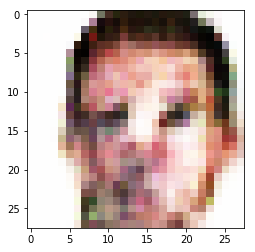

Epoch 30/40... Discriminator Loss: 1.0325... Generator Loss: 1.7007
Epoch 30/40... Discriminator Loss: 1.0213... Generator Loss: 1.4071
Epoch 30/40... Discriminator Loss: 0.9927... Generator Loss: 1.3750
Epoch 31/40... Discriminator Loss: 0.9799... Generator Loss: 1.1412
Epoch 31/40... Discriminator Loss: 1.2148... Generator Loss: 1.1817


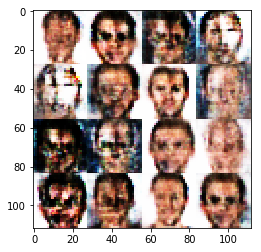

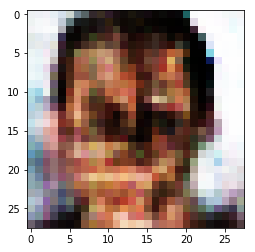

Epoch 31/40... Discriminator Loss: 1.0924... Generator Loss: 1.3211
Epoch 31/40... Discriminator Loss: 1.1063... Generator Loss: 1.2745
Epoch 31/40... Discriminator Loss: 0.8560... Generator Loss: 1.6251
Epoch 31/40... Discriminator Loss: 1.0163... Generator Loss: 1.4407
Epoch 31/40... Discriminator Loss: 1.0404... Generator Loss: 1.0827


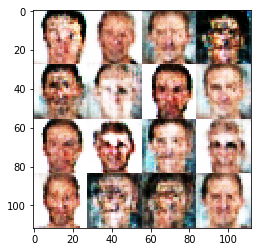

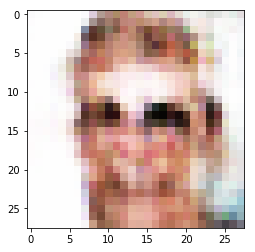

Epoch 32/40... Discriminator Loss: 0.7832... Generator Loss: 1.9683
Epoch 32/40... Discriminator Loss: 0.8656... Generator Loss: 1.4973
Epoch 32/40... Discriminator Loss: 0.9049... Generator Loss: 1.5577
Epoch 32/40... Discriminator Loss: 1.0441... Generator Loss: 1.5175
Epoch 32/40... Discriminator Loss: 1.0378... Generator Loss: 1.3867


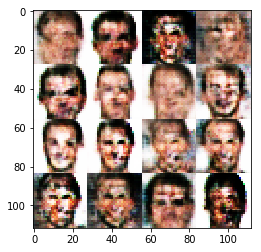

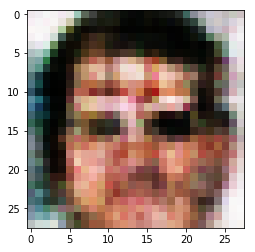

Epoch 32/40... Discriminator Loss: 0.9489... Generator Loss: 1.3310
Epoch 32/40... Discriminator Loss: 1.1679... Generator Loss: 0.8819
Epoch 33/40... Discriminator Loss: 0.9280... Generator Loss: 1.3046
Epoch 33/40... Discriminator Loss: 0.9392... Generator Loss: 1.3273
Epoch 33/40... Discriminator Loss: 0.7610... Generator Loss: 1.8019


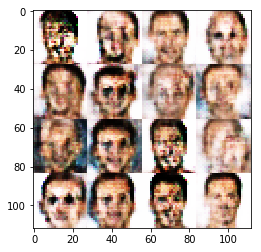

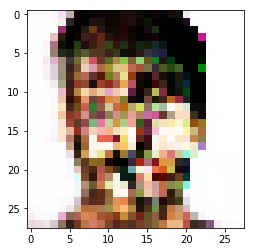

Epoch 33/40... Discriminator Loss: 1.1268... Generator Loss: 1.1961
Epoch 33/40... Discriminator Loss: 0.8657... Generator Loss: 1.5252
Epoch 33/40... Discriminator Loss: 0.7712... Generator Loss: 1.9865
Epoch 33/40... Discriminator Loss: 0.8130... Generator Loss: 1.3622
Epoch 34/40... Discriminator Loss: 0.7455... Generator Loss: 1.5257


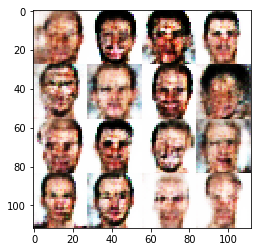

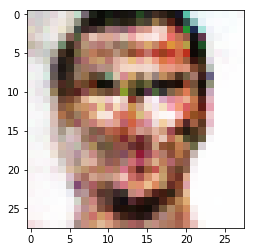

Epoch 34/40... Discriminator Loss: 1.0517... Generator Loss: 1.2051
Epoch 34/40... Discriminator Loss: 0.9473... Generator Loss: 2.1948
Epoch 34/40... Discriminator Loss: 0.7831... Generator Loss: 1.5927
Epoch 34/40... Discriminator Loss: 0.9604... Generator Loss: 1.7061
Epoch 34/40... Discriminator Loss: 0.8002... Generator Loss: 1.9121


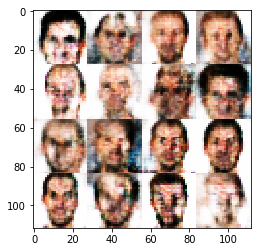

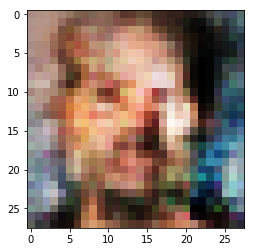

Epoch 34/40... Discriminator Loss: 0.9100... Generator Loss: 1.9234
Epoch 34/40... Discriminator Loss: 0.9446... Generator Loss: 1.5406
Epoch 35/40... Discriminator Loss: 0.9163... Generator Loss: 1.8104
Epoch 35/40... Discriminator Loss: 1.0273... Generator Loss: 1.3801
Epoch 35/40... Discriminator Loss: 1.1378... Generator Loss: 2.0315


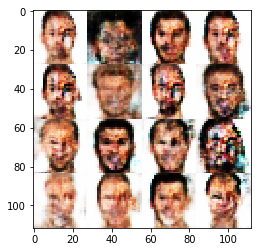

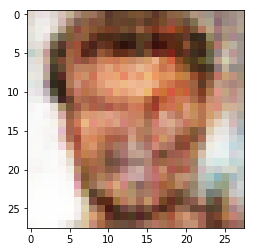

Epoch 35/40... Discriminator Loss: 0.6862... Generator Loss: 1.6675
Epoch 35/40... Discriminator Loss: 1.0214... Generator Loss: 1.2403
Epoch 35/40... Discriminator Loss: 0.8451... Generator Loss: 1.5566
Epoch 35/40... Discriminator Loss: 0.9729... Generator Loss: 1.2177
Epoch 36/40... Discriminator Loss: 1.0926... Generator Loss: 2.1522


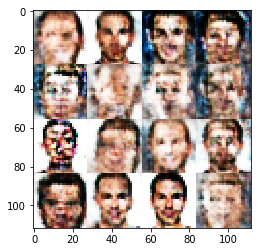

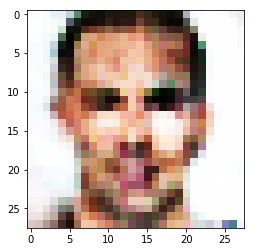

Epoch 36/40... Discriminator Loss: 0.9840... Generator Loss: 1.9588
Epoch 36/40... Discriminator Loss: 0.8439... Generator Loss: 1.5172
Epoch 36/40... Discriminator Loss: 0.9066... Generator Loss: 1.4910
Epoch 36/40... Discriminator Loss: 0.7850... Generator Loss: 1.6368
Epoch 36/40... Discriminator Loss: 0.8716... Generator Loss: 2.0907


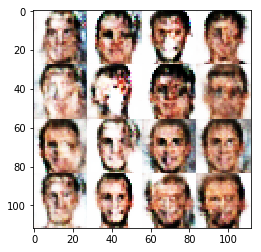

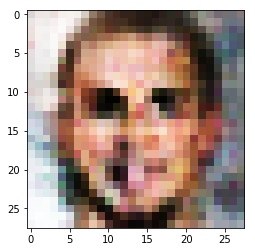

Epoch 36/40... Discriminator Loss: 0.9802... Generator Loss: 1.3816
Epoch 37/40... Discriminator Loss: 0.7859... Generator Loss: 2.0508
Epoch 37/40... Discriminator Loss: 0.7733... Generator Loss: 1.8790
Epoch 37/40... Discriminator Loss: 0.8636... Generator Loss: 1.5986
Epoch 37/40... Discriminator Loss: 0.8542... Generator Loss: 1.5826


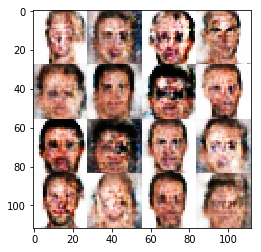

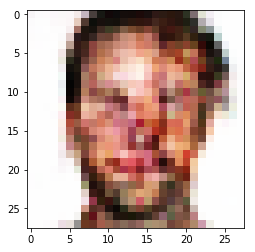

Epoch 37/40... Discriminator Loss: 0.7297... Generator Loss: 2.3403
Epoch 37/40... Discriminator Loss: 0.8093... Generator Loss: 1.7556
Epoch 37/40... Discriminator Loss: 0.8995... Generator Loss: 1.8051
Epoch 38/40... Discriminator Loss: 0.8972... Generator Loss: 1.5813
Epoch 38/40... Discriminator Loss: 0.8040... Generator Loss: 1.7001


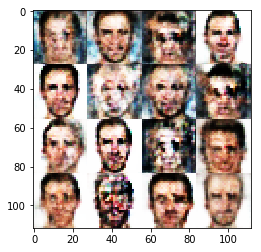

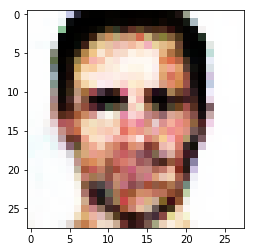

Epoch 38/40... Discriminator Loss: 0.8142... Generator Loss: 1.5321
Epoch 38/40... Discriminator Loss: 0.8377... Generator Loss: 1.2384
Epoch 38/40... Discriminator Loss: 0.9122... Generator Loss: 1.4493
Epoch 38/40... Discriminator Loss: 1.0658... Generator Loss: 1.4507
Epoch 38/40... Discriminator Loss: 1.0250... Generator Loss: 1.1180


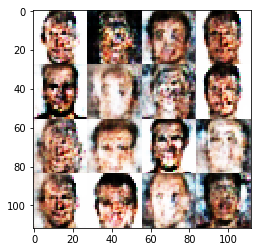

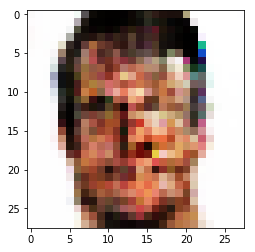

Epoch 39/40... Discriminator Loss: 0.8382... Generator Loss: 1.8647
Epoch 39/40... Discriminator Loss: 1.2911... Generator Loss: 1.0302
Epoch 39/40... Discriminator Loss: 0.8055... Generator Loss: 1.4551
Epoch 39/40... Discriminator Loss: 0.8710... Generator Loss: 1.6505
Epoch 39/40... Discriminator Loss: 0.8866... Generator Loss: 1.9250


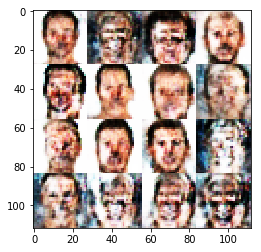

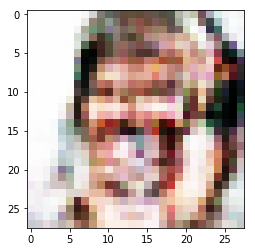

Epoch 39/40... Discriminator Loss: 0.9600... Generator Loss: 1.1159
Epoch 39/40... Discriminator Loss: 0.9211... Generator Loss: 1.8215
Epoch 39/40... Discriminator Loss: 0.8086... Generator Loss: 1.8521


In [84]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005

beta1 = 0.7

epochs = 40

nhl_dataset = Dataset('nhl', playerimg_paths)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, nhl_dataset.get_batches,
          nhl_dataset.shape, nhl_dataset.image_mode)